In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
%matplotlib inline

In [2]:
tf.__version__

'2.0.1'

In [3]:
tf.test.is_gpu_available()

True

In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration( gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3700)])

### load data

In [5]:
def load_img(img,lab):
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img, channels=1)
    img = tf.cast(img,tf.float32) ##???
    lab = tf.cast(lab,tf.float32)/2 #####???    turn 0,2,4 to 0,1,2 otherwise loss=NaN
    return img,lab

In [6]:
test_data=pd.read_csv('test.txt',header=None,sep=' ',names=['picture','label'])
train_data=pd.read_csv('train.txt',header=None,sep=' ',names=['picture','label'])
valid_data=pd.read_csv('valid.txt',header=None,sep=' ',names=['picture','label'])
# test_data.head()

In [7]:
test_data['dir']=[os.path.join('preprocessed','test',pic) for pic in test_data['picture']]
train_data['dir']=[os.path.join('preprocessed','train',pic) for pic in train_data['picture']]
valid_data['dir']=[os.path.join('preprocessed','valid',pic) for pic in valid_data['picture']]
# test_data.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018CDE81AC48>]],
      dtype=object)

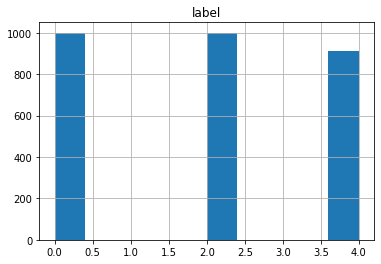

In [8]:
total_set = pd.concat([test_data,train_data,valid_data],ignore_index=True)
iid_total_set = pd.concat([total_set[total_set['label']==i*2][:1000] for i in range(3)])
iid_total_set.hist()

In [9]:
random_set = iid_total_set.sample(frac=1).reset_index(drop=True)

In [10]:
## settings
fraction_val = 0.1

valid_LEN=int(len(random_set)*fraction_val)
train_LEN=int(len(random_set)-valid_LEN)

batch_SIZE=3 ### should't be that small but my laptop....
train_EPO=int(train_LEN // batch_SIZE)
valid_EPO=int(valid_LEN // batch_SIZE)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018CAA72B948>]],
      dtype=object)

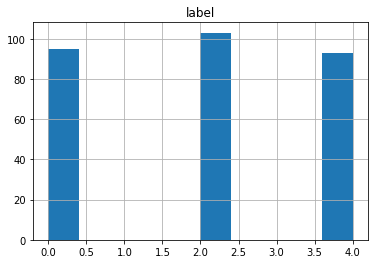

In [11]:
iid_valid = random_set[:valid_LEN]
iid_valid.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018CFFF24B88>]],
      dtype=object)

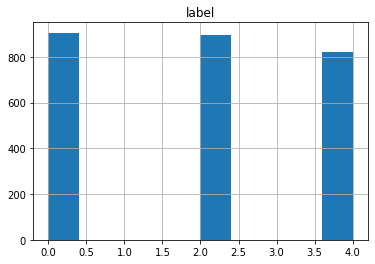

In [12]:
iid_train = random_set[valid_LEN:]
iid_train.hist()

In [13]:
train_SET = tf.data.Dataset.from_tensor_slices((iid_train['dir'],iid_train['label'])).\
                            shuffle(train_LEN).\
                            map(load_img).\
                            batch(batch_SIZE).\
                            repeat().\
                            prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_SET = tf.data.Dataset.from_tensor_slices((iid_valid['dir'],iid_valid['label'])).\
                            shuffle(valid_LEN).\
                            map(load_img).\
                            batch(batch_SIZE).\
                            repeat().\
                            prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
myshape = (512,512,1)
model = tf.keras.applications.xception.Xception(include_top=True, weights=None, input_shape=myshape, classes=6)
# it said include_top should be false if input_shape is not (229,229,3), but the only difference is to add avg_pooling and prediction

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
# model.summary()

In [ ]:
epo=100
history= model.fit(train_SET,
                  epochs=epo,
                  steps_per_epoch=train_EPO,
                  validation_data=valid_SET,
                  validation_steps=valid_EPO
                  )

Train for 874 steps, validate for 97 steps
Epoch 1/100
874/874 [==============================] - 450s 515ms/step - loss: 1.0723 - acc: 0.4535 - val_loss: 0.8424 - val_acc: 0.5498
Epoch 2/100
874/874 [==============================] - 443s 506ms/step - loss: 0.9428 - acc: 0.5137 - val_loss: 1.2212 - val_acc: 0.5808
Epoch 3/100
874/874 [==============================] - 443s 507ms/step - loss: 0.8880 - acc: 0.5538 - val_loss: 1.0910 - val_acc: 0.5945
Epoch 4/100
874/874 [==============================] - 442s 506ms/step - loss: 0.8338 - acc: 0.5934 - val_loss: 0.8436 - val_acc: 0.6117
Epoch 5/100
874/874 [==============================] - 442s 506ms/step - loss: 0.8206 - acc: 0.6087 - val_loss: 0.8362 - val_acc: 0.5876
Epoch 6/100
874/874 [==============================] - 442s 506ms/step - loss: 0.7865 - acc: 0.6526 - val_loss: 1.6765 - val_acc: 0.5636
Epoch 7/100
874/874 [==============================] - 441s 505ms/step - loss: 0.7609 - acc: 0.6514 - val_loss: 0.7018 - val_acc: 0.677

In [ ]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

In [ ]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

In [ ]:
model.save_weights('myXception.h5')

acc = history.history.get('acc')
val_acc = history.history.get('val_acc')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')


np.save("acc.npy", acc)
np.save("val_acc.npy", val_acc)
np.save("loss.npy", loss)
np.save("val_loss.npy", val_loss)